# Seq2Seq with Attention for Korean-English Neural Machine Translation
- Network architecture based on this [paper](https://arxiv.org/abs/1409.0473)
- Fit to run on Google Colaboratory

In [0]:
import os
import io
import time
import math
import random
import tarfile

import scipy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext

from torchtext.data import Dataset
from torchtext.data import Example
from torchtext.data import Field
from torchtext.data import BucketIterator

In [0]:
SEED = 2011170821

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# 1. Upload Data to Colab Workspace

로컬에 존재하는 다음 3개의 데이터를 가상 머신에 업로드. 파일의 원본은 [여기](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1/)에서도 확인

- korean-english-park.train.tar.gz
- korean-english-park.dev.tar.gz
- korean.english-park.test.tar.gz



In [3]:
# 현재 작업경로를 확인 & 'data' 폴더 생성
!echo 'Current working directory:' ${PWD}
!mkdir -p data/
!ls -al

Current working directory: /content
total 20
drwxr-xr-x 1 root root 4096 Aug  2 00:58 .
drwxr-xr-x 1 root root 4096 Aug  2 00:50 ..
drwxr-xr-x 1 root root 4096 Jul 30 16:17 .config
drwxr-xr-x 2 root root 4096 Aug  2 00:58 data
drwxr-xr-x 1 root root 4096 Jul 30 16:17 sample_data


In [4]:
# 로컬의 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving korean-english-park.dev.tar.gz to korean-english-park.dev.tar.gz
Saving korean-english-park.test.tar.gz to korean-english-park.test.tar.gz
Saving korean-english-park.train.tar.gz to korean-english-park.train.tar.gz


In [5]:
# 'data' 폴더 하위로 이동, 잘 옮겨졌는지 확인
!mv *.tar.gz data/
!ls -al data/

total 8864
drwxr-xr-x 2 root root    4096 Aug  2 01:00 .
drwxr-xr-x 1 root root    4096 Aug  2 01:00 ..
-rw-r--r-- 1 root root  113461 Aug  2 00:58 korean-english-park.dev.tar.gz
-rw-r--r-- 1 root root  229831 Aug  2 00:58 korean-english-park.test.tar.gz
-rw-r--r-- 1 root root 8718893 Aug  2 01:00 korean-english-park.train.tar.gz


# 2. Check Packages

## KoNLPy (설치 필요)

In [6]:
# Java 1.8 & KoNLPy 설치
!apt-get update
!apt-get install g++ openjdk-8-jdk python-dev python3-dev
!pip3 install JPype1-py3
!pip3 install konlpy

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:12 https://developer.download.nvidia.com/compute/machine-learning/repos

In [7]:
from konlpy.tag import Okt
ko_tokens = Okt().pos('트위터 데이터로 학습한 한글 형태소 분석기가 잘 실행이 되는지 확인해볼까요?')  # list of (word, POS TAG) tuples
ko_tokens = [t[0] for t in ko_tokens]  # Only get words
print(ko_tokens)

del ko_tokens  # 필요 없으니까 삭제

/usr/local/lib/python3.6/dist-packages/jpype/_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


['트위터', '데이터', '로', '학습', '한', '한글', '형태소', '분석', '기', '가', '잘', '실행', '이', '되는지', '확인', '해볼까', '요', '?']


## Spacy (이미 설치되어 있음)

In [8]:
# 설치가 되어있는지 확인
!pip show spacy

Name: spacy
Version: 2.1.6
Summary: Industrial-strength Natural Language Processing (NLP) with Python and Cython
Home-page: https://spacy.io
Author: Explosion AI
Author-email: contact@explosion.ai
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: thinc, cymem, blis, murmurhash, plac, srsly, requests, numpy, preshed, wasabi
Required-by: fastai, en-core-web-sm


In [9]:
# 설치가 되어있는지 확인 (없다면 자동설치됨)
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [10]:
import spacy
spacy_en = spacy.load('en_core_web_sm')
en_tokens = [t.text for t in spacy_en.tokenizer('Check that spacy tokenizer works.')]
print(en_tokens)

del en_tokens  # 필요 없으니까 삭제

['Check', 'that', 'spacy', 'tokenizer', 'works', '.']


# 3. Define Tokenizing Functions
문장을 받아 그보다 작은 어절 혹은 형태소 단위의 리스트로 반환해주는 함수를 각 언어에 대해 작성
- Korean: konlpy.tag.Okt() <- Twitter()에서 명칭변경
- English: spacy.tokenizer

## Korean Tokenizer

In [0]:
#from konlpy.tag import Okt

class KoTokenizer(object):
    """For Korean."""
    def __init__(self):
        self.tokenizer = Okt()
        
    def tokenize(self, text):
        tokens = self.tokenizer.pos(text)
        tokens = [t[0] for t in tokens]
        return tokens

In [12]:
# Usage example
print(KoTokenizer().tokenize('내가 만들 수 없는 것, 나는 이해할 수 없다.'))

['내', '가', '만들', '수', '없는', '것', ',', '나', '는', '이해', '할', '수', '없다', '.']


## English Tokenizer

In [0]:
#import spacy

class EnTokenizer(object):
    """For English."""
    def __init__(self):
        self.spacy_en = spacy.load('en_core_web_sm')
        
    def tokenize(self, text):
        tokens = [t.text for t in self.spacy_en.tokenizer(text)]
        return tokens

In [14]:
# Usage example
print(EnTokenizer().tokenize("What I cannot create, I don't understand."))

['What', 'I', 'can', 'not', 'create', ',', 'I', 'do', "n't", 'understand', '.']


# 4. Data Preprocessing

## Load data

In [15]:
# Current working directory & list of files
!echo 'Current working directory:' ${PWD}
!ls -al

Current working directory: /content
total 20
drwxr-xr-x 1 root root 4096 Aug  2 01:00 .
drwxr-xr-x 1 root root 4096 Aug  2 00:50 ..
drwxr-xr-x 1 root root 4096 Jul 30 16:17 .config
drwxr-xr-x 2 root root 4096 Aug  2 01:00 data
drwxr-xr-x 1 root root 4096 Jul 30 16:17 sample_data


In [16]:
DATA_DIR = './data/'
print('Data directory exists:', os.path.isdir(DATA_DIR))
print('List of files:')
print(*os.listdir(DATA_DIR), sep='\n')

Data directory exists: True
List of files:
korean-english-park.test.tar.gz
korean-english-park.dev.tar.gz
korean-english-park.train.tar.gz


In [0]:
def get_data_from_tar_gz(filename):
    """
    Retrieve contents from a `tar.gz` file without extraction.
    Arguments:
        filename: path to `tar.gz` file.
    Returns:
        dict, (name, content) pairs
    """
    
    assert os.path.exists(filename)
    
    out = {}
    with tarfile.open(filename, 'r:gz') as tar:
        for member in tar.getmembers():
            lang = member.name.split('.')[-1]  # ex) korean-english-park.train.ko -> ko
            f = tar.extractfile(member)
            if f is not None:
                content = f.read().decode('utf-8')
                content = content.splitlines()
                out[lang] = content
    
    assert isinstance(out, dict)
    
    return out

In [0]:
# Each 'xxx_data' is a dictionary with keys; 'ko', 'en'
train_dict= get_data_from_tar_gz(os.path.join(DATA_DIR, 'korean-english-park.train.tar.gz'))  # train
dev_dict = get_data_from_tar_gz(os.path.join(DATA_DIR, 'korean-english-park.dev.tar.gz'))     # dev
test_dict = get_data_from_tar_gz(os.path.join(DATA_DIR, 'korean-english-park.test.tar.gz'))   # test

In [19]:
# Some samples (ko)
train_dict['ko'][100:103]

['제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.',
 '1,960만갤론 이상의 중유를 운반하던 손상된 유조선이 스페인 북서부 연안 130마일 해역에서 침몰하여, 스페인 당국이 어업이 주요 산업인 이 지역에서 해안선 보호를 위해 황급히 서두르고 있다.',
 '싣고 있는 기름이 모두 유출된다면, 알라스카州 프린스 윌리암 사운드에서 1989년에 발생했던 엑손 발데즈 기름 유출 사건의 규모보다 두 배 이상이 되는 사상 최대 규모의 기름 유출 사건 중의 하나가 될 것이라고 세계 야생 생물 기금이 경고하고 있다.']

In [20]:
# Some samples (en)
train_dict['en'][100:103]

['Gates, who opened the 23rd annual Comdex trade show, said there was a negative perception of high tech following the collapse of the tech bubble about two years ago.',
 "carrying more than 19.6 million gallons of heavy fuel oil sank 130 miles off Spain's northwest coast, leaving Spanish authorities scrambling to protect the coastline in the region where fishing is the primary industry.",
 "The World Wildlife Fund warns that if all of the oil leaked, it would be one of the largest oil spills ever more than twice the size of the 1989 Exxon Valdez spill in Alaska's Prince William Sound."]

## Define Datasets

In [0]:
#from torchtext.data import Dataset
#from torchtext.data import Example

class KoEnTranslationDataset(Dataset):
    """A dataset for Korean-English Neural Machine Translation."""

    def __init__(self, data_dict, field_dict, source_lang='ko', max_samples=None, **kwargs):
        """
        Only 'ko' and 'en' supported for `language`
        Arguments: 
            data_dict: dict of (`language`, text) pairs.
            field_dict: dict of (`language`, Field instance) pairs.
            source_lang: str, default 'ko'.
            Other kwargs are passed to the constructor of `torchtext.data.Dataset`.
        """
        
        if not all(k in ['ko', 'en'] for k in data_dict.keys()):
            raise KeyError("Check data keys.")
            
        if not all(k in ['ko', 'en'] for k in field_dict.keys()):
            raise KeyError("Check field keys.")
            
        if source_lang == 'ko':
            fields = [('src', field_dict['ko']), ('trg', field_dict['en'])]
            src_data = data_dict['ko']
            trg_data = data_dict['en']
        elif source_lang == 'en':
            fields = [('src', field_dict['en']), ('trg', field_dict['ko'])]
            src_data = data_dict['en']
            trg_data = data_dict['ko']
        else:
            raise NotImplementedError
        

        if not len(src_data) == len(trg_data):
            raise ValueError('Inconsistent number of instances between two languages.')
        
        examples = []
        for i, (src_line, trg_line) in enumerate(zip(src_data, trg_data)):
            src_line = src_line.strip()
            trg_line = trg_line.strip()
            if src_line != '' and trg_line != '':
                
                examples.append(
                    torchtext.data.Example.fromlist(
                        [src_line, trg_line], fields
                    )
                )
                
                i += 1
                if max_samples is not None:
                    if i >= max_samples:
                        break
                    
        super(KoEnTranslationDataset, self).__init__(examples, fields, **kwargs)
        

## Define Fields
- Instantiate tokenizers; one for each language.
- The 'tokenize' argument of `Field` requires a tokenizing function.

In [0]:
#from torchtext.data import Field

ko_tokenizer = KoTokenizer()  # korean tokenizer
en_tokenizer = EnTokenizer()  # english tokenizer

# Field instance for korean
KOREAN = Field(
    init_token='<sos>',
    eos_token='<eos>',
    tokenize=ko_tokenizer.tokenize,
    batch_first=False,
    lower=False,
    include_lengths=True,
)

# Field instance for english
ENGLISH = Field(
    init_token='<sos>',
    eos_token='<eos>',
    tokenize=en_tokenizer.tokenize,
    batch_first=False,
    lower=True,
    include_lengths=True,
)

# Store Field instances in a dictionary
field_dict = {
    'ko': KOREAN,
    'en': ENGLISH,
}

## Instantiate datasets
- one for each set (train, dev, test)

In [0]:
# 학습시간 단축을 위해 학습 데이터 줄이기
MAX_TRAIN_SAMPLES = 25000

In [24]:
# Instantiate with data
train_set = KoEnTranslationDataset(train_dict, field_dict, max_samples=MAX_TRAIN_SAMPLES)
print('Train set ready.')
print('#. examples:', len(train_set.examples))

dev_set = KoEnTranslationDataset(dev_dict, field_dict)
print('Dev set ready...')
print('#. examples:', len(dev_set.examples))

test_set = KoEnTranslationDataset(test_dict, field_dict)
print('Test set ready...')
print('#. examples:', len(test_set.examples))

Train set ready.
#. examples: 25000
Dev set ready...
#. examples: 1000
Test set ready...
#. examples: 2000


In [25]:
# Training example (KO, source language)
train_set.examples[50].src

['신랑',
 '들러리',
 '가',
 '포도주',
 '잔',
 '을',
 '들어',
 '올린다',
 '그리고는',
 '술',
 '주정',
 '을',
 '늘어놓는다',
 '.']

In [26]:
# Training example (EN, target language)
train_set.examples[50].trg

['the',
 'best',
 'man',
 'raises',
 'his',
 'wine',
 'glass',
 'and',
 'out',
 'comes',
 'a',
 'drunken',
 'diatribe',
 '.']

## Build Vocabulary
- 각 언어별 생성: `Field`의 인스턴스를 활용
- 최소 빈도수(`MIN_FREQ`) 값을 작게 하면 vocabulary의 크기가 커짐.
- 최소 빈도수(`MIN_FREQ`) 값을 크게 하면 vocabulary의 크기가 작아짐.


In [0]:
MIN_FREQ = 7  # TODO: try different values

### Korean vocab

In [28]:
# Build vocab for Korean
KOREAN.build_vocab(train_set, min_freq=MIN_FREQ)  # ko
print('Size of source vocab (ko):', len(KOREAN.vocab))

Size of source vocab (ko): 8209


In [29]:
KOREAN.vocab.freqs.most_common(10)

[('.', 24796),
 ('을', 19093),
 ('이', 18054),
 ('의', 14821),
 ('에', 14066),
 ('은', 12701),
 ('를', 11349),
 ('는', 11121),
 ('했다', 10034),
 ('들', 9064)]

In [30]:
# Check indices of some important tokens
tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
for token in tokens:
    print(f"{token} -> {KOREAN.vocab.stoi[token]}")

<unk> -> 0
<pad> -> 1
<sos> -> 2
<eos> -> 3


### English vocab

In [31]:
# Build vocab for English
ENGLISH.build_vocab(train_set, min_freq=MIN_FREQ)  # en
print('Size of target vocab (en):', len(ENGLISH.vocab))

Size of target vocab (en): 7274


In [32]:
ENGLISH.vocab.freqs.most_common(10)

[('the', 35676),
 (',', 29561),
 ('.', 25184),
 ('to', 15041),
 ('of', 14776),
 ('a', 14157),
 ('in', 13218),
 ('and', 13047),
 ('"', 8981),
 ("'s", 6196)]

In [33]:
# Check indices of some important tokens
tokens = ['<unk>', '<pad>', '<sos>', '<eos>']
for token in tokens:
    print(f"{token} -> {ENGLISH.vocab.stoi[token]}")

<unk> -> 0
<pad> -> 1
<sos> -> 2
<eos> -> 3


## Configure Device
- *'런타임'  -> '런타임 유형변경'* 에서 하드웨어 가속기로 **GPU** 선택

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device to use:', device)

Device to use: cuda


## Create Data Iterators
- 데이터를 미니배치(mini-batch) 단위로 반환해주는 역할
- `train_set`, `dev_set`, `test_set`에 대해 개별적으로 정의해야 함
- `BATCH_SIZE`를 정의해주어야 함
- `torchtext.data.BucketIterator`는 하나의 미니배치를 서로 비슷한 길이의 관측치들로 구성함
- [Bucketing](https://medium.com/@rashmi.margani/how-to-speed-up-the-training-of-the-sequence-model-using-bucketing-techniques-9e302b0fd976)의 효과: 하나의 미니배치 내 padding을 최소화하여 연산의 낭비를 줄여줌


In [0]:
BATCH_SIZE = 128

In [36]:
#from torchtext.data import BucketIterator

# Train iterator
train_iterator = BucketIterator(
    train_set,
    batch_size=BATCH_SIZE,
    train=True,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device,
)

print(f'Number of minibatches per epoch: {len(train_iterator)}')

Number of minibatches per epoch: 196


In [37]:
#from torchtext.data import BucketIterator

# Dev iterator
dev_iterator = BucketIterator(
    dev_set,
    batch_size=BATCH_SIZE,
    train=False,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

print(f'Number of minibatches per epoch: {len(dev_iterator)}')

Number of minibatches per epoch: 8


In [38]:
#from torchtext.data import BucketIterator

# Test iterator
test_iterator = BucketIterator(
    test_set,
    batch_size=200,
    train=False,
    sort_within_batch=True,
    sort_key=lambda x: len(x.src),
    device=device
)

print(f'Number of minibatches per epoch: {len(test_iterator)}')

Number of minibatches per epoch: 10


In [39]:
train_batch = next(iter(train_iterator))
src, src_len = train_batch.src
trg, trg_len = train_batch.trg
print('a batch of source examples has shape:', src.size())  # (s, b)
print('a batch of target examples has shape:', trg.size())  # (s, b)

a batch of source examples has shape: torch.Size([27, 128])
a batch of target examples has shape: torch.Size([48, 128])


In [40]:
src

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [  42,  705,  138,  ...,   65,    6, 1615],
        [ 735, 1144,  576,  ...,   26,   13,   11],
        ...,
        [  29,  145,    0,  ..., 1215,    4,    4],
        [   4,    4,    4,  ...,    3,    3,    3],
        [   3,    3,    3,  ...,    1,    1,    1]], device='cuda:0')

In [41]:
src_len # sorted in descending order

tensor([27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
        27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26], device='cuda:0')

In [42]:
trg

tensor([[   2,    2,    2,  ...,    2,    2,    2],
        [   4,    0,   11,  ...,   34,   40, 1451],
        [1119,   11,  108,  ...,   25,   29,    0],
        ...,
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1],
        [   1,    1,    1,  ...,    1,    1,    1]], device='cuda:0')

In [43]:
trg_len  # 뒤죽박죽

tensor([21, 20, 33, 25, 18, 24, 20, 18, 23, 31, 20, 40, 26, 21, 24, 17, 38, 40,
        28, 23, 28, 29, 32, 24, 13, 37, 23, 30, 31, 21, 30, 34, 25, 45, 29, 35,
        16, 28, 25, 28, 27, 29, 18, 24, 31, 24, 29, 32, 23, 45, 23, 21, 29, 24,
        20, 48, 38, 29, 37, 22, 25, 19, 30, 22, 25, 28, 22, 21, 22,  9, 20, 15,
        22, 32, 32, 25, 19, 16, 25, 17, 26, 30, 35, 30, 23, 19, 23, 25, 23, 19,
        31, 21, 24, 33, 25, 17, 29, 12, 28, 16, 18, 25, 23, 35, 29, 22, 30, 17,
        29, 33, 26, 33, 20, 26, 37, 35, 21, 27, 23, 21, 29, 24, 21, 27, 22, 23,
        15, 25], device='cuda:0')

In [44]:
# Checking last sample in mini-batch (KO, source lang)
src, srg_len = train_batch.src
ko_indices = src[:, -1]
ko_tokens = [KOREAN.vocab.itos[i] for i in ko_indices]
for t, i in zip(ko_tokens, ko_indices):
    print(f"{t} ({i})")
    
del ko_indices, ko_tokens

<sos> (2)
케네디 (1615)
는 (11)
병원 (258)
밖 (1025)
으로 (19)
나오면서 (4377)
시민 (676)
들 (13)
과 (28)
지지자 (415)
들 (13)
을 (5)
향 (682)
해 (50)
<unk> (0)
을 (5)
펼쳐 (7366)
보이 (1158)
며 (48)
차량 (329)
에 (8)
탑승 (1492)
했다 (12)
. (4)
<eos> (3)
<pad> (1)


In [45]:
# Checking last sample in mini-batch (EN, target lang)
trg, trg_len = train_batch.trg
en_indices = trg[:, -1]
en_tokens = [ENGLISH.vocab.itos[i] for i in en_indices]
for t, i in zip(en_tokens, en_indices):
    print(f"{t} ({i})")
    
del en_indices, en_tokens

<sos> (2)
kennedy (1451)
<unk> (0)
to (7)
the (4)
crowd (1063)
of (8)
reporters (616)
and (11)
<unk> (0)
and (11)
gave (643)
a (9)
¡ (216)
° (249)
<unk> (0)
<unk> (0)
sign (1045)
before (117)
getting (762)
into (85)
a (9)
car (430)
. (6)
<eos> (3)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)
<pad> (1)


# 5. Building Seq2Seq Model

## Hyperparameters

In [46]:
# Hyperparameters
INPUT_DIM = len(KOREAN.vocab)
OUTPUT_DIM = len(ENGLISH.vocab)
ENC_EMB_DIM = DEC_EMB_DIM = 256
ENC_HID_DIM = DEC_HID_DIM = 300
USE_BIDIRECTIONAL = False

print('source vocabulary size:', INPUT_DIM)
print('source word embedding size:', ENC_EMB_DIM)
print(f'encoder RNN hidden size: {ENC_HID_DIM} ({ENC_HID_DIM * 2} if bidirectional)')
print('-' * 50)
print('target vocabulary size:', OUTPUT_DIM)
print('target word embedding size:', ENC_EMB_DIM)
print('decoder RNN hidden size:', ENC_HID_DIM)

source vocabulary size: 8209
source word embedding size: 256
encoder RNN hidden size: 300 (600 if bidirectional)
--------------------------------------------------
target vocabulary size: 7274
target word embedding size: 256
decoder RNN hidden size: 300


## Encoder

In [0]:
class Encoder(nn.Module):
    """
    Learns an embedding for the source text.
        Arguments:
        input_dim: int, size of input language vocabulary.
        emb_dim: int, size of embedding layer output.
        enc_hid_dim: int, size of encoder hidden state.
        dec_hid_dim: int, size of decoder hidden state.
        bidirectional: uses bidirectional RNNs if True. default is False.
    """
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, bidirectional=False):
        
        super(Encoder, self).__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(
            num_embeddings=self.input_dim,
            embedding_dim=self.emb_dim
        )
        
        self.rnn = nn.GRU(
            input_size=self.emb_dim,
            hidden_size=self.enc_hid_dim,
            bidirectional=self.bidirectional,
            batch_first=False
        )
        
        self.rnn_output_dim = self.enc_hid_dim
        if self.bidirectional:
            self.rnn_output_dim *= 2
        
        self.fc = nn.Linear(self.rnn_output_dim, self.dec_hid_dim)
        self.dropout = nn.Dropout(.2)
        
    def forward(self, src, src_len):
        """
        Arguments:
            src: 2d tensor of shape (S, B)
            src_len: 1d tensor of shape (B).
        Returns:
            outputs: 3d tensor of shape (input_seq_len, batch_size, num_directions * enc_h)
            hidden: 2d tensor of shape (b, dec_h). This tensor will be used as the initial
                hidden state value of the decoder (h0 of decoder).
        """
        
        assert len(src.size()) == 2, 'Input requires dimension (input_seq_len, batch_size).'
        
        # Shape: (b, s, h)
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len)
        packed_outputs, hidden = self.rnn(packed_embedded)
        
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        
        if self.bidirectional:
            # (2, b, enc_h) -> (b, 2 * enc_h)
            hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        else:
            # (1, b, enc_h) -> (b, enc_h)
            hidden = hidden.squeeze(0)
        
        # (b, num_directions * enc_h) -> (b, dec_h)
        hidden = self.fc(hidden)
        hidden = torch.tanh(hidden)
        
        return outputs, hidden  # (S, B, enc_h * num_directions), (B, dec_h)

## Attention

In [0]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim, encoder_is_bidirectional=False):
        super(Attention, self).__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.encoder_is_bidirectional = encoder_is_bidirectional
        
        self.attention_input_dim = enc_hid_dim + dec_hid_dim
        if self.encoder_is_bidirectional:
            self.attention_input_dim += enc_hid_dim  # 2 * h_enc + h_dec
        
        self.linear = nn.Linear(self.attention_input_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        """
        Arguments:
            hidden: 2d tensor with shape (batch_size, dec_hid_dim).
            encoder_outputs: 3d tensor with shape (input_seq_len, batch_size, enc_hid_dim * num_directions).
            mask: 2d tensor with shape(batch_size, input_seq_len)
        """
        
        # Shape check
        assert hidden.dim() == 2
        assert encoder_outputs.dim() == 3
        
        seq_len, batch_size, _ = encoder_outputs.size()
        
        # (b, dec_h) -> (b, s, dec_h)
        hidden = hidden.unsqueeze(1).expand(-1, seq_len, -1)
        
        # (s, b, enc_h * num_directions) -> (b, s, enc_h * num_directions)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # concat; shape results in (b, s, enc_h + dec_h).
        # if encoder is bidirectional, (b, s, 2 * h_enc + h_dec).
        concat = torch.cat((hidden, encoder_outputs), dim=2)
        
        # energy; shape is (b, s, dec_h)
        energy = torch.tanh(self.linear(concat))
        
        # tile v; (dec_h, ) -> (b, dec_h) -> (b, dec_h, 1)
        v = self.v.unsqueeze(0).expand(batch_size, -1).unsqueeze(2)
        
        # attn; (b, s, dec_h) @ (b, dec_h, 1) -> (b, s, 1) -> (b, s)
        attn_scores = torch.bmm(energy, v).squeeze(-1)
        
        # mask padding indices
        attn_scores = attn_scores.masked_fill(mask == 0, -1e10)
        
        assert attn_scores.dim() == 2  # Final shape check: (b, s)
        
        return F.softmax(attn_scores, dim=1)

## Decoder

In [0]:
class Decoder(nn.Module):
    """
    Unlike the encoder, a single forward pass of
    a `Decoder` instance is defined for only a single timestep.
    Arguments:
        output_dim: int,
        emb_dim: int,
        enc_hid_dim: int,
        dec_hid_dim: int,
        attention_module: torch.nn.Module,
        encoder_is_bidirectional: False
    """
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, attention_module, encoder_is_bidirectional=False):
        super(Decoder, self).__init__()
        
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.encoder_is_bidirectional = encoder_is_bidirectional
        
        if isinstance(attention_module, nn.Module):
            self.attention_module = attention_module
        else:
            raise ValueError
        
        self.rnn_input_size = enc_hid_dim + emb_dim  # enc_h + dec_emb_dim
        if self.encoder_is_bidirectional:
            self.rnn_input_size += enc_hid_dim       # 2 * enc_h + dec_emb_dim
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU(
            input_size=self.rnn_input_size,
            hidden_size=dec_hid_dim,
            bidirectional=False,
            batch_first=False,
        )
        
        self.out_input_size = emb_dim + dec_hid_dim + enc_hid_dim
        if self.encoder_is_bidirectional:
            self.out_input_size += enc_hid_dim
        self.out = nn.Linear(self.out_input_size, output_dim)
        
        self.dropout = nn.Dropout(.2)
        
    def forward(self, inp, hidden, encoder_outputs, mask, temperature=1.):
        """
        Arguments:
            inp: 1d tensor with shape (batch_size, )
            hidden: 2d tensor with shape (batch_size, dec_hid_dim).
                This `hidden` tensor is the hidden state vector from the previous timestep.
            encoder_outputs: 3d tensor with shape (input_seq_len, batch_size, enc_hid_dim * num_directions).
            mask: 2d tensor of shape (batch_size, input_seq_len).
        """
        
        assert inp.dim() == 1
        assert hidden.dim() == 2
        assert encoder_outputs.dim() == 3
        
        # (b, ) -> (1, b)
        inp = inp.unsqueeze(0)
        
        # (1, b) -> (1, b, emb)
        embedded = self.embedding(inp)
        embedded = self.dropout(embedded)
                
        # attention probabilities; (b, s)
        attn_probs = self.attention_module(hidden, encoder_outputs, mask)
        
        # (b, 1, s)
        attn_probs = attn_probs.unsqueeze(1)
        
        # (s, b, ~) -> (b, s, ~)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        # (b, 1, s) @ (b, s, ~) -> (b, 1, enc_h * num_directions)
        weighted = torch.bmm(attn_probs, encoder_outputs)
        
        # (1, b, ~)
        weighted = weighted.permute(1, 0, 2)
        
        # (b, 1, emb + enc_h * num_directions)
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        # output; (b, 1, dec_h)
        # new_hidden; (1, b, dec_h)
        output, new_hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        assert (output == new_hidden).all()
        
        embedded = embedded.squeeze(0)  # (1, b, emb) -> (b, emb)
        output = output.squeeze(0)      # (1, b, dec_h) -> (b, dec_h)
        weighted = weighted.squeeze(0)  # (1, b, enc_h * num_d) -> (b, enc_h * num_d)
        
        # output; (b, emb + enc_h + dec_h) -> (b, output_dim)
        # if encoder is bidirectional, (b, emb + 2 * enc_h + dec_h) -> (b, output_dim)
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        output = output / temperature
        
        return output, new_hidden.squeeze(0), attn_probs.squeeze(1)

## Seq2Seq

In [0]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super(Seq2Seq, self).__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx  # 1
        self.sos_idx = sos_idx  # 2
        self.eos_idx = eos_idx  # 3
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)  # (b, s)
        return mask
        
    def forward(self, src, src_len, trg=None, teacher_forcing_ratio=.5):
        
        batch_size = src.size(1)
        max_seq_len = trg.size(0) if trg is not None else 100
        
        trg_vocab_size = self.decoder.output_dim
        
        if trg is None:
            assert teacher_forcing_ratio == 0., "Must be zero during inference."
            inference = True
            trg = torch.zeros(max_seq_len, batch_size).long().fill_(self.sos_idx).to(self.device)
        else:
            inference = False
            
        # An empty tensor to store decoder outputs (time index first for faster indexing)
        outputs_shape = (max_seq_len, batch_size, trg_vocab_size)
        outputs = torch.zeros(outputs_shape).to(self.device)
        
        # empty tensor to store attention probs
        attns_shape = (max_seq_len, batch_size, src.size(0))
        attns = torch.zeros(attns_shape).to(self.device)
        
        encoder_outputs, hidden = self.encoder(src, src_len)
        mask = self.create_mask(src)
        
        # first input to the decoder is '<sos>'
        # trg; shape (batch_size, seq_len)
        initial_dec_input = output = trg[0, :]  # get first timestep token
        
        for t in range(1, max_seq_len):
            
            output, hidden, attn = self.decoder(output, hidden, encoder_outputs, mask)
            outputs[t] = output  # Save output for timestep t, for 1 <= t <= max_len
            attns[t] = attn
            
            _, idx = output.max(dim=1)
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            
            new_dec_input = output = trg[t] if teacher_force else idx
            
            if inference and output.item() == self.eos_idx:
                return outputs[:t], attns[:t]
        
        return outputs, attns

## Build Model

In [51]:
# Define encoder
enc = Encoder(
    input_dim=INPUT_DIM,
    emb_dim=ENC_EMB_DIM,
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    bidirectional=USE_BIDIRECTIONAL
)

print(enc)

Encoder(
  (embedding): Embedding(8209, 256)
  (rnn): GRU(256, 300)
  (fc): Linear(in_features=300, out_features=300, bias=True)
  (dropout): Dropout(p=0.2)
)


In [52]:
# Define attention layer
attn = Attention(
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    encoder_is_bidirectional=USE_BIDIRECTIONAL
)

print(attn)

Attention(
  (linear): Linear(in_features=600, out_features=300, bias=True)
)


In [53]:
# Define decoder
dec = Decoder(
    output_dim=OUTPUT_DIM,
    emb_dim=DEC_EMB_DIM,
    enc_hid_dim=ENC_HID_DIM,
    dec_hid_dim=DEC_HID_DIM,
    attention_module=attn,
    encoder_is_bidirectional=USE_BIDIRECTIONAL
)

print(dec)

Decoder(
  (attention_module): Attention(
    (linear): Linear(in_features=600, out_features=300, bias=True)
  )
  (embedding): Embedding(7274, 256)
  (rnn): GRU(556, 300)
  (out): Linear(in_features=856, out_features=7274, bias=True)
  (dropout): Dropout(p=0.2)
)


In [54]:
PAD_IDX = KOREAN.vocab.stoi['<pad>']
SOS_IDX = ENGLISH.vocab.stoi['<sos>']
EOS_IDX = ENGLISH.vocab.stoi['<eos>']

print('PAD INDEX:', PAD_IDX)
print('SOS INDEX:', SOS_IDX)
print('EOS INDEX:', EOS_IDX)

PAD INDEX: 1
SOS INDEX: 2
EOS INDEX: 3


In [55]:
model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8209, 256)
    (rnn): GRU(256, 300)
    (fc): Linear(in_features=300, out_features=300, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (decoder): Decoder(
    (attention_module): Attention(
      (linear): Linear(in_features=600, out_features=300, bias=True)
    )
    (embedding): Embedding(7274, 256)
    (rnn): GRU(556, 300)
    (out): Linear(in_features=856, out_features=7274, bias=True)
    (dropout): Dropout(p=0.2)
  )
)


## Count trainable parameters

In [56]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters.')

The model has 11,742,766 trainable parameters.


## Initialize trainable parameters

In [57]:
def init_parameters(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0., std=0.01)
        else:
            nn.init.constant_(param.data, 0.)

model.apply(init_parameters)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(8209, 256)
    (rnn): GRU(256, 300)
    (fc): Linear(in_features=300, out_features=300, bias=True)
    (dropout): Dropout(p=0.2)
  )
  (decoder): Decoder(
    (attention_module): Attention(
      (linear): Linear(in_features=600, out_features=300, bias=True)
    )
    (embedding): Embedding(7274, 256)
    (rnn): GRU(556, 300)
    (out): Linear(in_features=856, out_features=7274, bias=True)
    (dropout): Dropout(p=0.2)
  )
)

# 6. Train

## Optimizer
- Use `optim.Adam` or `optim.RMSprop`.

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.RMSprop(model.parameters(), lr=0.01)

## Loss function

In [59]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
print(f"<pad> index in target vocab (en): '{PAD_IDX}' will be ignored when loss is calculated.")

<pad> index in target vocab (en): '1' will be ignored when loss is calculated.


## Train function

In [0]:
def train(seq2seq_model, iterator, optimizer, criterion, grad_clip=1.0):
    
    seq2seq_model.train()
    
    epoch_loss = .0
    
    for i, batch in enumerate(iterator):
        
        print('.', end='')
        
        src, src_len = batch.src
        trg, _ = batch.trg
        
        optimizer.zero_grad()
        
        decoder_outputs, _ = seq2seq_model(src, src_len, trg, teacher_forcing_ratio=.5)
        trg_seq_len, batch_size, trg_vocab_size = decoder_outputs.size()  # (s, b, trg_vocab)
        
        # (s-1, b, trg_vocab)
        decoder_outputs = decoder_outputs[1:]
        
        # (s-1 * b, trg_vocab)
        decoder_outputs = decoder_outputs.view(-1, trg_vocab_size)
        
        # (s, b) -> (s-1 * b, )
        trg = trg[1:].view(-1)                                       

        loss = criterion(decoder_outputs, trg)
        loss.backward()
        
        # Gradient clipping; remedy for exploding gradients
        torch.nn.utils.clip_grad_norm_(seq2seq_model.parameters(), grad_clip)
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

## Evaluate function

In [0]:
def evaluate(seq2seq_model, iterator, criterion):
    
    seq2seq_model.eval()
    
    epoch_loss = 0.
    
    with torch.no_grad():
        
        for i, batch in enumerate(iterator):
            
            print('.', end='')
            
            src, src_len = batch.src
            trg, _ = batch.trg
            
            decoder_outputs, _ = seq2seq_model(src, src_len, trg, teacher_forcing_ratio=0.)
            trg_seq_len, batch_size, trg_vocab_size = decoder_outputs.size()  # (s, b, trg_vocab)
        
            # (s-1, b, trg_vocab)
            decoder_outputs = decoder_outputs[1:]                 
        
            # (s-1 * b, trg_vocab)
            decoder_outputs = decoder_outputs.view(-1, trg_vocab_size)
            
            # (s, b) -> (s-1 * b, )
            trg = trg[1:].view(-1)
            
            loss = criterion(decoder_outputs, trg)
            
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

## Epoch time measure function

In [0]:
def epoch_time(start_time, end_time):
    """Returns elapsed time in mins & secs."""
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Train for multiple epochs

In [0]:
NUM_EPOCHS = 30

In [65]:
best_dev_loss = float('inf')

for epoch in range(NUM_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion)
    dev_loss = evaluate(model, dev_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if dev_loss < best_dev_loss:
        best_dev_loss = dev_loss
        torch.save(model.state_dict(), './best_model_ko2en.pt')
    
    print("\n")
    print(f"Epoch: {epoch + 1:>02d} | Time: {epoch_mins}m {epoch_secs}s")
    print(f"Train Loss: {train_loss:>.4f} | Train Perplexity: {math.exp(train_loss):7.3f}")
    print(f"Dev Loss: {dev_loss:>.4f} | Dev Perplexity: {math.exp(dev_loss):7.3f}")    

............................................................................................................................................................................................................

Epoch: 01 | Time: 2m 53s
Train Loss: 6.3219 | Train Perplexity: 556.640
Dev Loss: 6.1265 | Dev Perplexity: 457.842
............................................................................................................................................................................................................

Epoch: 02 | Time: 2m 54s
Train Loss: 5.8275 | Train Perplexity: 339.519
Dev Loss: 6.0274 | Dev Perplexity: 414.639
............................................................................................................................................................................................................

Epoch: 03 | Time: 2m 53s
Train Loss: 5.6241 | Train Perplexity: 277.034
Dev Loss: 5.9986 | Dev Perplexity: 402.858
.....................................

## Save last model (overfitted)

In [0]:
torch.save(model.state_dict(), './last_model_ko2en.pt')

# 7. Test

## Evaluate on test data

In [68]:
model.load_state_dict(torch.load('best_model_ko2en.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

..........| Test Loss: 5.830 | Test PPL: 340.444 |


## Function to convert indices to original text strings (translate)



In [0]:
def translate_sentence(seq2seq_model, sentence):
    
    seq2seq_model.eval()
    
    # Tokenize sentence
    tokenized = KoTokenizer().tokenize(sentence)
    
    # Add <sos> & <eos> tokens to the front and back of the sentence
    tokenized = ['<sos>'] + tokenized + ['<eos>']
    
    # tokens -> indices
    numericalized = [KOREAN.vocab.stoi[s] for s in tokenized]
    
    sent_length = torch.tensor([len(numericalized)]).long().to(device)
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device)
    
    translation_logits, attention = seq2seq_model(tensor, sent_length, None, 0.)
    translation_tensor = torch.argmax(translation_logits.squeeze(1), dim=1)
    translation = [ENGLISH.vocab.itos[i] for i in translation_tensor]
    translation, attention = translation[1:], attention[1:]
    
    #assert translation.__len__() == 1  # (sequence_length, )
    #assert attention.dim() == 2
    
    return translation, attention

In [0]:
def display_attention(candidate, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels([''] + ['<sos>'] + [t.lower() for t in KoTokenizer().tokenize(candidate)] + ['<eos>'], 
                       rotation=45)
    ax.set_yticklabels([''] + translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [79]:
example_idx = 4
src = ' '.join(train_set.examples[example_idx].src)
trg = ' '.join(train_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')

src = 정보 관리 들 은 동남 아시아 에서의 선박 들 에 대한 많은 ( 테러 ) 계획 들 이 실패 로 돌아갔 음 을 밝혔으며 , 세계 해상 교 역량 의 거의 3분 의 1 을 운송 하는 좁은 해로인 말라카 해협 이 테러 공격 을 당하기 쉽다고 경고 하고 있다 .
trg = intelligence officials have revealed a spate of foiled plots on ships in southeast asia and are warning that a narrow stretch of water carrying almost one third of the world 's maritime trade is vulnerable to a terror attack .


In [80]:
translation, attention = translate_sentence(model, src)
print(f'predicted = {translation}')

predicted = ['the', '<unk>', ',', 'the', '<unk>', 'the', '<unk>', 'of', 'the', '<unk>', ',', 'the', '<unk>', '<unk>', ',', 'the', '<unk>', '<unk>', ',', 'the', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.']


## Alignment

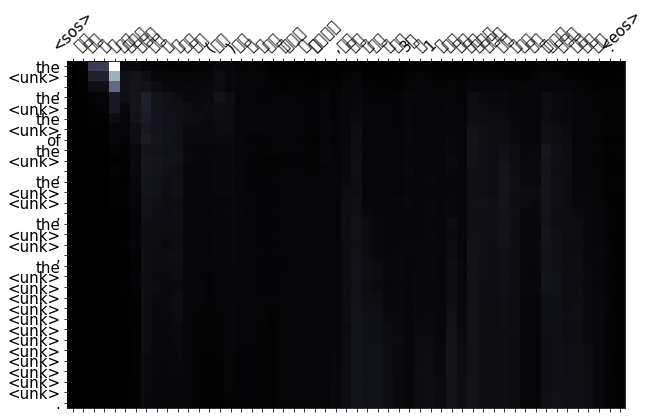

In [81]:
display_attention(src, translation, attention)

src = 최근 벨 연구소 의 한 연구원 은 숙련 된 사용자 라면 " 클리퍼 칩 " 의 보안 기능 을 피해 갈 수 있게 하는 " 클리퍼 칩 " 의 결함 을 밝혀 냈다 .
trg = recently a researcher for bell laboratories uncovered a flaw in the chip that would allow an experienced user to bypass its security function .
predicted trg = ['"', 'the', '<unk>', 'of', 'the', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '"', '<unk>', '"', '<unk>', '"', '<unk>', '"', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.']


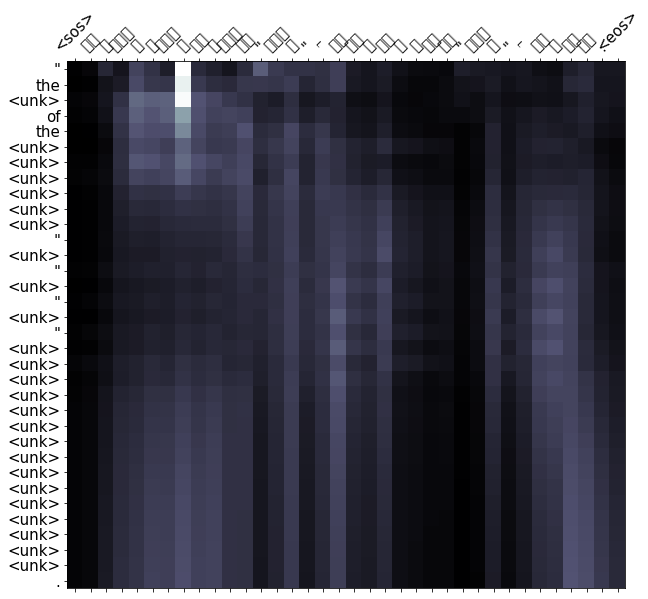

In [82]:
example_idx = 35

src = ' '.join(dev_set.examples[example_idx].src)
trg = ' '.join(dev_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(model, src)
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

src = 전갈 로 가득 찬 방 에서 가장 오래 머물러 있기에 대한 세계 기록 을 깨고 싶어 하는 30 세 의 태국 여인 칸차 나 케트 키우는 앞 으로 32일 동안 맹독 을 지닌 동거 자 들 과 함께 잠 을 잘 때 에 잠들지 못 하는 일 은 없을 것 이라고 자신 한 다 .
trg = hoping to break the world record for the longest stay in a room full of scorpions , she wo n't lose any sleep with her deadly roommates .
predicted trg = ['the', '<unk>', ',', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '.']


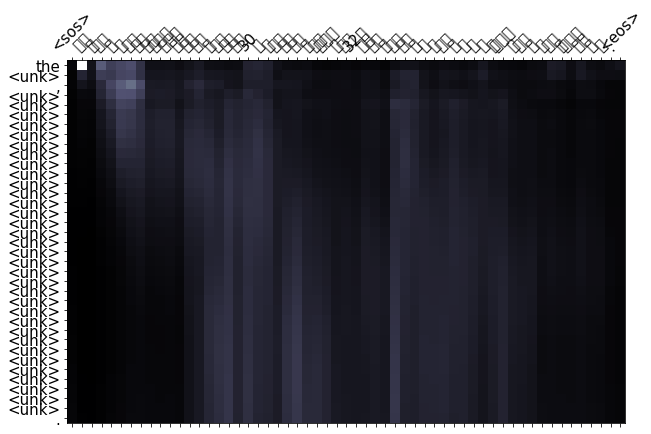

In [83]:
example_idx = 7

src = ' '.join(test_set.examples[example_idx].src)
trg = ' '.join(test_set.examples[example_idx].trg)

print(f'src = {src}')
print(f'trg = {trg}')


translation, attention = translate_sentence(model, src)
print(f'predicted trg = {translation}')

display_attention(src, translation, attention)

# 8. Download Model

In [0]:
!ls -al

total 43004
drwxr-xr-x 1 root root     4096 Aug  1 04:40 .
drwxr-xr-x 1 root root     4096 Aug  1 00:21 ..
-rw-r--r-- 1 root root 22006424 Aug  1 04:10 best_model.pt
drwxr-xr-x 1 root root     4096 Jul 19 16:14 .config
drwxr-xr-x 2 root root     4096 Aug  1 00:25 data
-rw-r--r-- 1 root root 22006424 Aug  1 04:40 last_model.pt
drwxr-xr-x 1 root root     4096 Jul 19 16:14 sample_data


In [0]:
from google.colab import files
print('Downloading best model...')  # Known bug; if using Firefox, a print statement in the same cell is necessary.
files.download('./best_model_ko2en.pt')

In [0]:
print('Downloading last model...')
files.download('./last_model_ko2en.pt')

# 9. Discussions